# Downloading historical Uniswap data using Python and Google Big Query


This is a tutorial to download raw data from the Ethereum blockchain using Google Big Query. This tutorial is intended to be a "first step" in ur series of research bites, as many of them will rely upon pool data. 


### Requirements

We will require the following Python libraries:

-  pandas
-  matplotlib
-  google.cloud
-  google.oauth2

You will require Google Big Query credentials. Follow [This tutorial](https://cloud.google.com/bigquery/docs/authentication/service-account-file) to obtain this. Once you have your .json credentials file, keep it in the same folder as this notebook (or alternatively, modify the path below). Assume now that you named your credentials file `tutorialGBQKey.json` and that it is located in same folder as this notebook (so `./`).


### Fetching the data

In this short tutorial we will fetch the [USDC-ETH Uniswap v3 pool at 0.3%](https://info.uniswap.org/#/pools/0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8), whose ID  is given by `0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8`. We remark, however, that the methods outlined herein can easily be extended to any other pool. 

We begin by importing the required libraries. 

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import tqdm
from google.cloud import bigquery
from google.oauth2 import service_account
import matplotlib.dates as mdates

PATH_TO_KEY="./tutorialGBQKey.json"
credentials = service_account.Credentials.from_service_account_file(PATH_TO_KEY)
client = bigquery.Client(credentials= credentials)

We next create our query using SQL. In particular, we will use the public Google Big Query database  `bigquery-public-data.crypto_ethereum.logs`, which stores the logs of all daily transactions in the Ethereum blockchain. The schema of such a table is shown below:


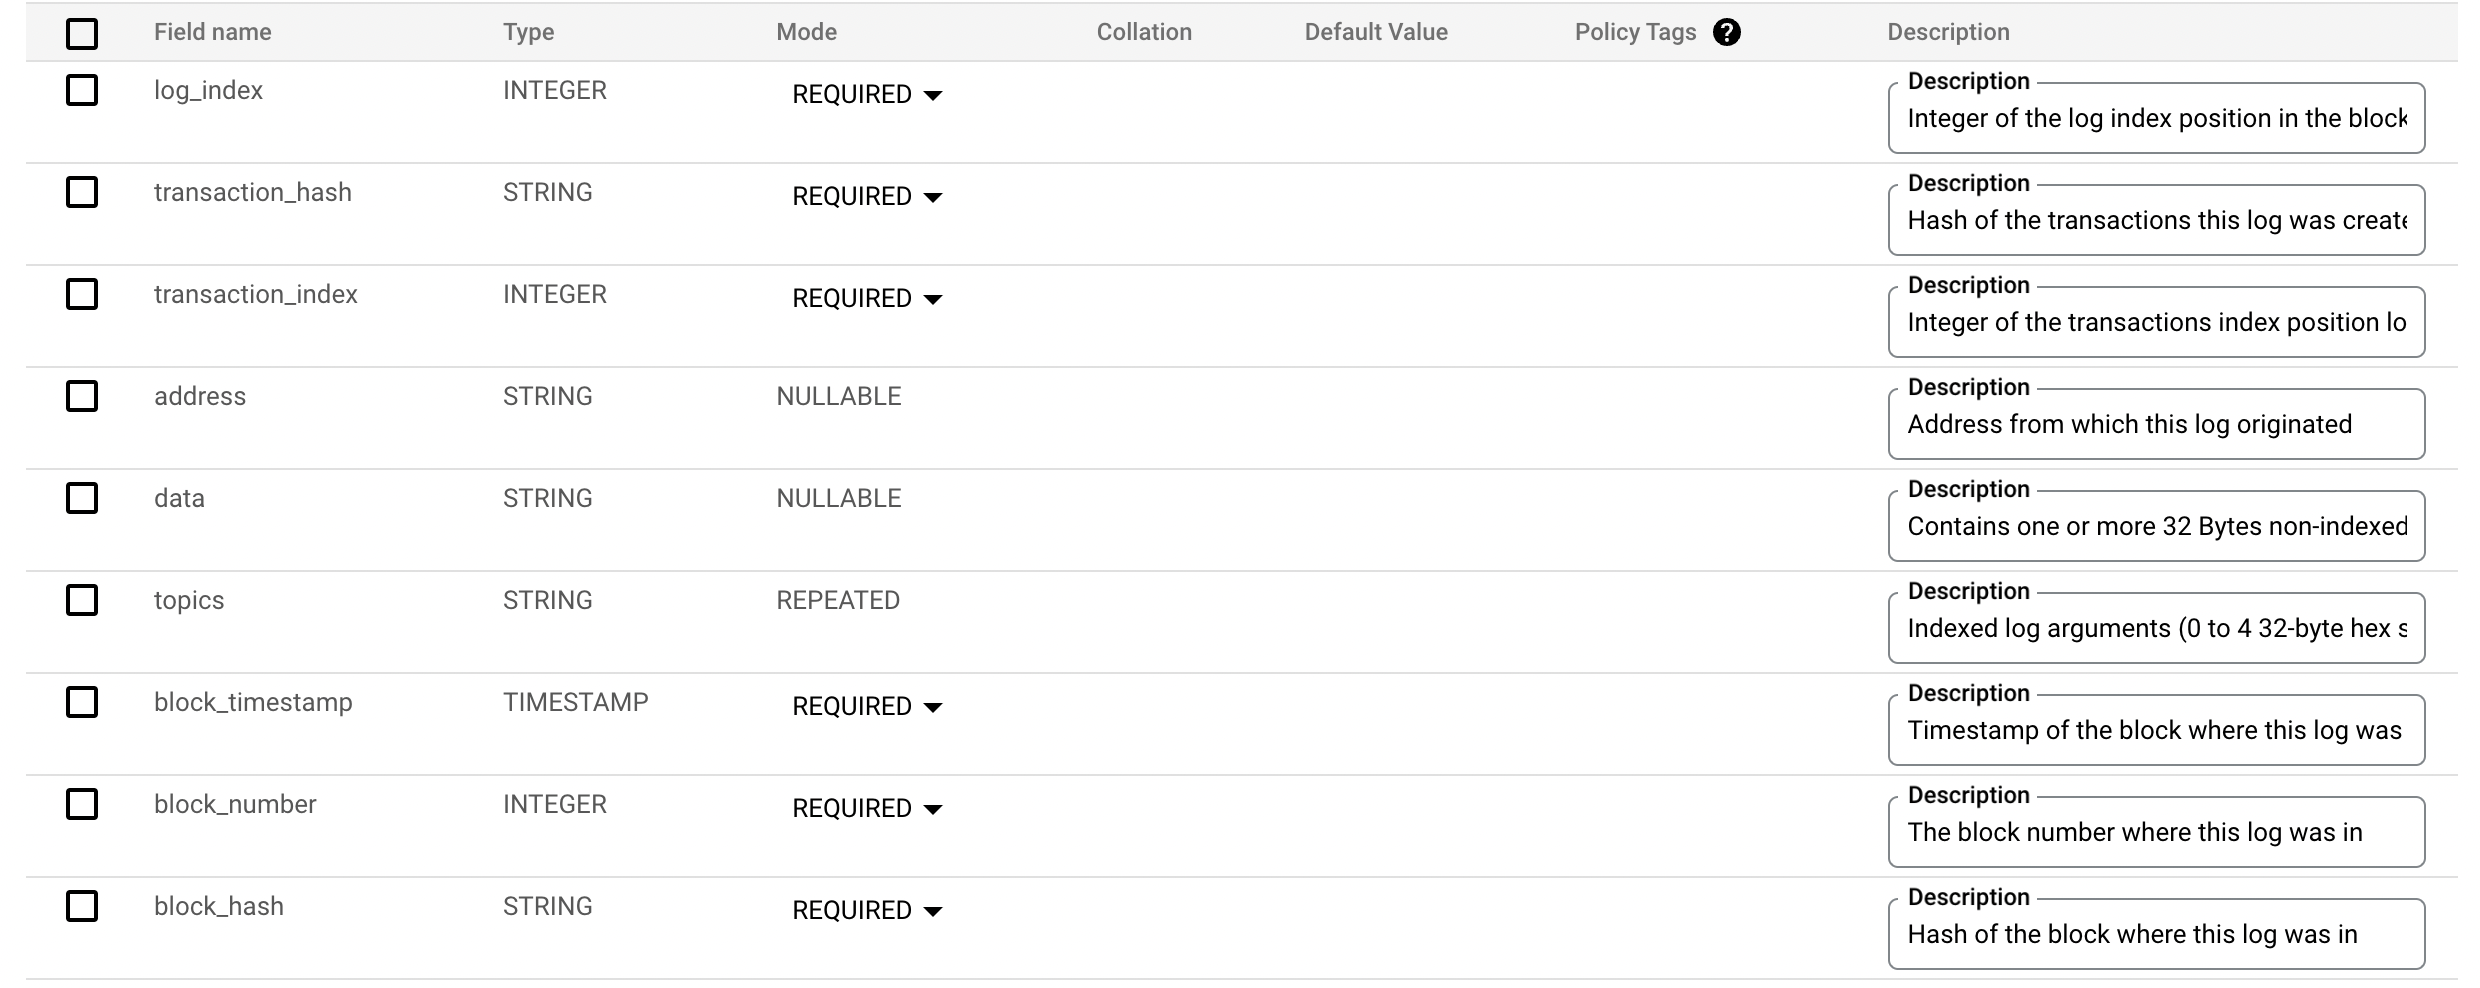


Most of the information that we are interested on is in the field `Data`. In particular, when this field is not empty, it contains 4 64-character (hex) strings representing: the amount of token0, the amount of token1, the square root of the price and the liquidity in the pool. It furthermore contains an integer representing the current tick of the pool. All of these concepts are thoroughly explained in the [UniswapV3 whitepaper](https://uniswap.org/whitepaper-v3.pdf).

Given this, we can use the following SQL code to query our data. In short, the query selects the relevant rows from the public ethereum logs database, filters by the pool address, and sorts in order of ascending block timestamp. Notice the comments describing the relvant chunks of the code

```sql
--Selects the fields we want
SELECT
  address,
  block_number,
  transaction_hash,
  block_timestamp, 
  transaction_index
  --Extracts the relevant data from the "Data" field
  CONCAT('0x',(CAST(SUBSTRING(Data, 3, 64) as string))) as amount0,
  CONCAT('0x',(CAST(SUBSTRING(Data, 67, 64) as string))) as amount1,
  CONCAT('0x',(CAST(SUBSTRING(Data, 131, 64) as string))) as sqrtPrice,  
  CONCAT('0x',(CAST(SUBSTRING(Data, 195, 64) as string))) as liquidity,
  --Extracts the tick data 
IF
  ((CAST(CONCAT('0x',(CAST(SUBSTRING(DATA, 317, 16) AS string))) AS int)) > CAST('0xf00000' AS int), (CAST(CONCAT('0x',(CAST(SUBSTRING(DATA, 317, 16) AS string))) AS int))- CAST('0xffffff' AS int), CAST(CONCAT('0x',(CAST(SUBSTRING(DATA, 317, 16) AS string))) AS int)) AS tick
  --specifies the table we want to query
FROM
  `bigquery-public-data.crypto_ethereum.logs`
-- Makes sure we are *not* querying empty fields  
WHERE
  DATA != ""
  AND transaction_hash != ""
    -- This is the pool we want (USDC-ETH-0.3%. Make sure to change it! 
  AND address = lower("0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8")
  AND (CAST(SUBSTRING(DATA, 259, 64) AS string)) != ''
  -- Makes sure we are not querying empty fields  
ORDER BY
  -- Sorts by block timestamp and trx index  
  block_timestamp ASC, transaction_index
```


We can now use pandas to get our query

In [138]:
POOL_ADDRESS="0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8"
query='''
SELECT
  address,
  block_number,
  transaction_hash,
  block_timestamp,
  log_index,
  transaction_index,
  CONCAT('0x',(CAST(SUBSTRING(Data, 3, 64) as string))) as amount0,
  CONCAT('0x',(CAST(SUBSTRING(Data, 67, 64) as string))) as amount1,
  CONCAT('0x',(CAST(SUBSTRING(Data, 131, 64) as string))) as sqrtPrice,  
  CONCAT('0x',(CAST(SUBSTRING(Data, 195, 64) as string))) as liquidity,     
IF
  ((CAST(CONCAT('0x',(CAST(SUBSTRING(DATA, 317, 16) AS string))) AS int)) > CAST('0xf00000' AS int), (CAST(CONCAT('0x',(CAST(SUBSTRING(DATA, 317, 16) AS string))) AS int))- CAST('0xffffff' AS int), CAST(CONCAT('0x',(CAST(SUBSTRING(DATA, 317, 16) AS string))) AS int)) AS tick
FROM
  `bigquery-public-data.crypto_ethereum.logs`
WHERE
  DATA != ""
  AND transaction_hash != ""
  AND address = lower("{}")
  AND (CAST(SUBSTRING(DATA, 259, 64) AS string)) != ''
ORDER BY
  block_timestamp ASC, transaction_index'''.format(POOL_ADDRESS)
print('⏰ performing the query...')
try:
    df = client.query(query).to_dataframe()
    print('🟢 Done!')
except:
    print('🟠 There was an issue querying the data!')


⏰ performing the query...
🟢 Done!


Let's explore our dataframe:

In [102]:
df.head(5)

,address,block_number,transaction_hash,block_timestamp,log_index,transaction_index,amount0,amount1,sqrtPrice,liquidity,tick
0,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,12371376,0xce7c3c307d820785caa12938012372fc9366a614a6aa...,2021-05-05 01:56:23+00:00,26,20,0xffffffffffffffffffffffffffffffffffffffffffff...,0x00000000000000000000000000000000000000000000...,0x00000000000000000000000000000000000043eff50f...,0x00000000000000000000000000000000000000000000...,195285
1,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,12373132,0x9a1c51b0bffbf840948f3b6e3f3e495ba1cd3fa64854...,2021-05-05 08:23:26+00:00,192,172,0xffffffffffffffffffffffffffffffffffffffffffff...,0x00000000000000000000000000000000000000000000...,0x00000000000000000000000000000000000043fb8a8c...,0x00000000000000000000000000000000000000000000...,195298
2,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,12373520,0xc58715c62a5bf70a6ca09f0e51546d6cad76c8d4fff0...,2021-05-05 09:50:51+00:00,8,18,0xffffffffffffffffffffffffffffffffffffffffffff...,0x00000000000000000000000000000000000000000000...,0x00000000000000000000000000000000000043fb907b...,0x00000000000000000000000000000000000000000000...,195298
3,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,12374077,0x288c21b8b4fbf449b1d086a06e43b124ac2bc088c3f5...,2021-05-05 11:59:57+00:00,86,102,0x00000000000000000000000000000000000000000000...,0xffffffffffffffffffffffffffffffffffffffffffff...,0x00000000000000000000000000000000000043fb907b...,0x00000000000000000000000000000000000000000000...,195298
4,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,12374320,0x67502d8ba373287f6d301f6baa77c5a5f4c80d0753c3...,2021-05-05 12:56:56+00:00,257,115,0x00000000000000000000000000000000000000000000...,0xffffffffffffffffffffffffffffffffffffffffffff...,0x000000000000000000000000000000000000438ee140...,0x00000000000000000000000000000000000000000000...,195173


As we can see, `amount0`, `amount1`, `sqrtPrice` and `liquidity` are all in hex. Let us convert them to a more human-readable format. We will define some auxiliary functions to that end. Recall that, USDC is a token with 6 digits, while (w)ETH is a token with 18 digits. Furthermore, recall that price as a function of tick is given by 


\begin{equation}
\text{Price}(\text{tick})=1.0001^{\text{tick}}
\end{equation}

Thus, we can compute the amounts by converting the HEX into floats using the method `get_twos_comp` below, and the price with the formula above. Notice that in this particular pool, ETH is the default num\'eraire (i.e., price is given in ETH per USDC). To make it more readable, we exchange the order of the num\'eraire and the asset (returning a price in USDC per ETH, using the `convert_price` method below. 

In [139]:
DIGITS_TOKEN0=6
DIGITS_TOKEN1=18
UNIV3_BASE=1.0001

def convert_price(p: float, dec_0: int, dec_1: int) -> float:
    """Gets inverse price"""
    return 10 ** (dec_1 - dec_0) / p

def get_twos_comp(hex_str, bits: int=256):
    """Calculate two's complement"""
    num = int(hex_str, 16)
    if (num & (1 << (bits - 1))) != 0: # Check if first bit is set
        num = num - (1 << bits)        # Get two's complement
    return num

Having defined these functions, we are now ready to "clean" our dataset

In [140]:
df['amount0']=df['amount0'].apply(get_twos_comp)/ (10 ** DIGITS_TOKEN0)
df['amount1']=df['amount1'].apply(get_twos_comp)/ (10 ** DIGITS_TOKEN1)
df['sqrtPrice']=df['sqrtPrice'].apply(get_twos_comp)//(2**96)
df['price'] = df['tick'].apply(lambda x: convert_price(UNIV3_BASE**x,DIGITS_TOKEN0,DIGITS_TOKEN1))
df.head(5)

,address,block_number,transaction_hash,block_timestamp,log_index,transaction_index,amount0,amount1,sqrtPrice,liquidity,tick,price
0,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,12371376,0xce7c3c307d820785caa12938012372fc9366a614a6aa...,2021-05-05 01:56:23+00:00,26,20,-0.329608,0.0001,17391,0x00000000000000000000000000000000000000000000...,195285,3306.010571
1,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,12373132,0x9a1c51b0bffbf840948f3b6e3f3e495ba1cd3fa64854...,2021-05-05 08:23:26+00:00,192,172,-164.694492,0.05,17403,0x00000000000000000000000000000000000000000000...,195298,3301.715764
2,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,12373520,0xc58715c62a5bf70a6ca09f0e51546d6cad76c8d4fff0...,2021-05-05 09:50:51+00:00,8,18,-0.329169,0.0001,17403,0x00000000000000000000000000000000000000000000...,195298,3301.715764
3,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,12374077,0x288c21b8b4fbf449b1d086a06e43b124ac2bc088c3f5...,2021-05-05 11:59:57+00:00,86,102,0.000002,-0.0,17403,0x00000000000000000000000000000000000000000000...,195298,3301.715764
4,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,12374320,0x67502d8ba373287f6d301f6baa77c5a5f4c80d0753c3...,2021-05-05 12:56:56+00:00,257,115,1559.137299,-0.467881,17294,0x00000000000000000000000000000000000000000000...,195173,3343.244146


As we can see, all relevant quantities are given in floats and integers, as opposed to HEX. lastly, we plot the price of the ETH in the pool:

/var/folders/wz/tdmt_j1d4_d876mcvb5071480000gn/T/ipykernel_1503/1496051789.py:13: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.gcf().autofmt_xdate(rotation=60)


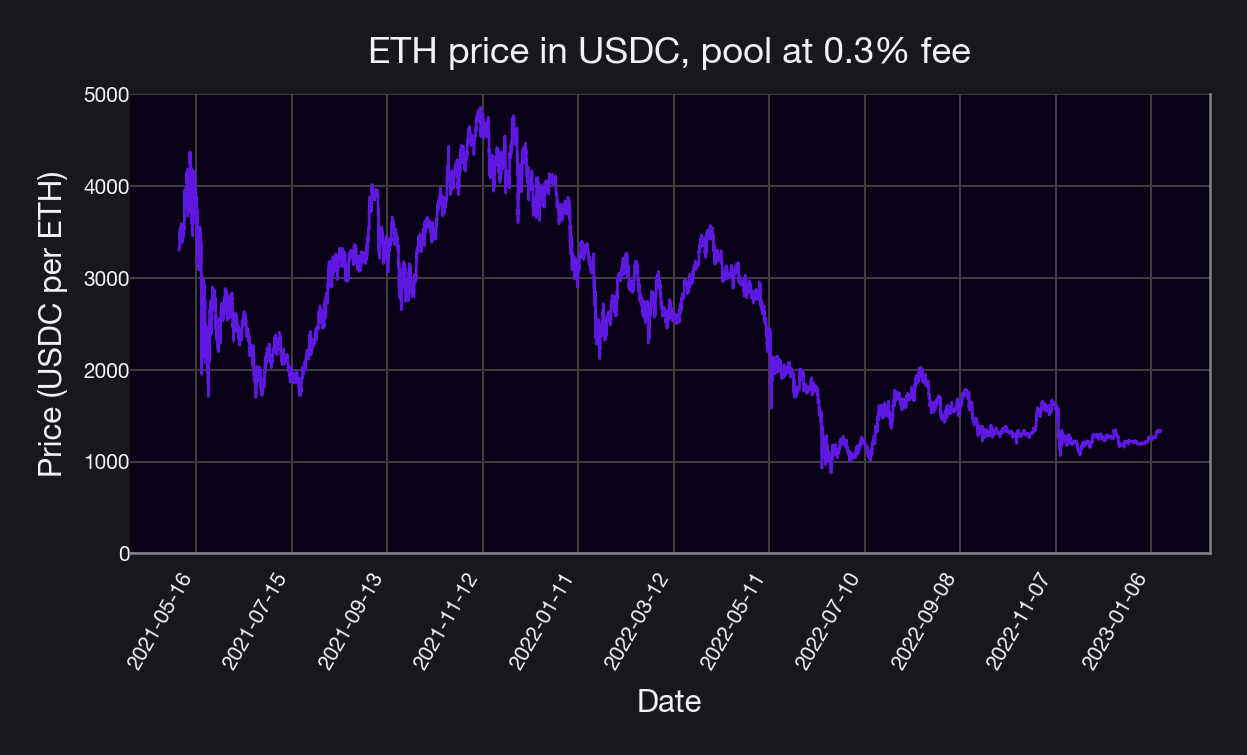

In [141]:
plt.style.use('../../stylesheet/panoptic-dark-2_1.mplstyle')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
plt.plot(df['block_timestamp'],df['price'])
plt.xlabel('Date')
plt.ylabel('Price (USDC per ETH)')
plt.title('ETH price in USDC, pool at 0.3% fee')
visible_ticks = {
   "top": False,
   "right": False
}
plt.tick_params(axis="x", which="both", **visible_ticks)
plt.gcf().autofmt_xdate(rotation=60)
plt.ylim([0,5000])

import svgutils.compose as sc
# Save as a temp svg file
plt.savefig('price.png')
plt.show()

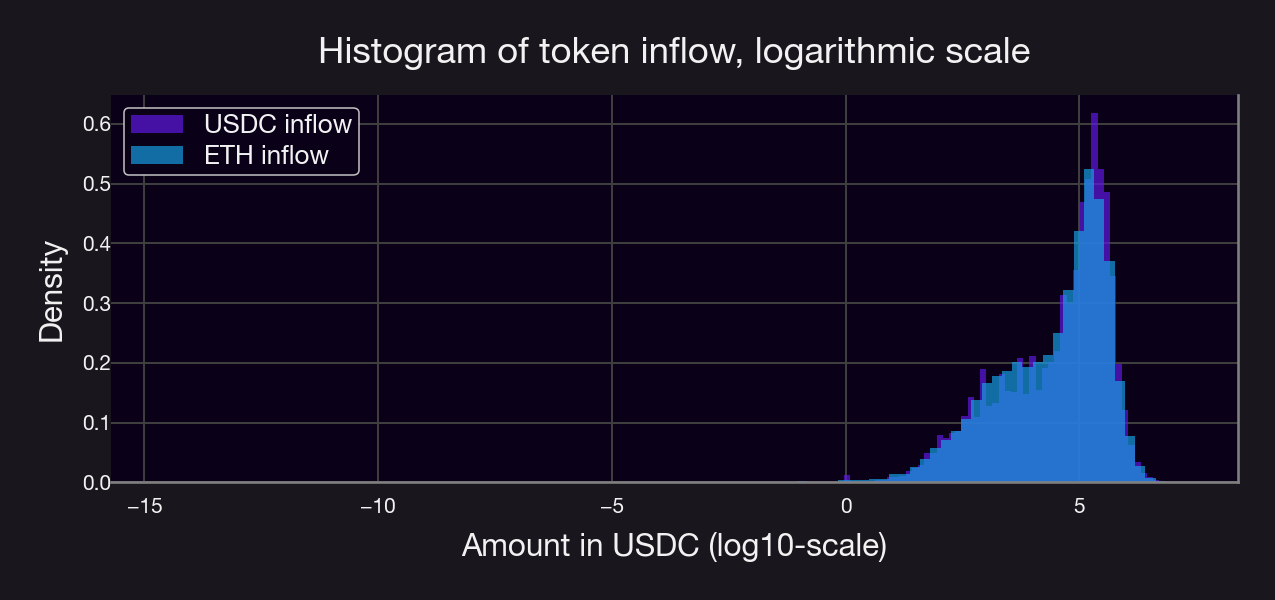

In [150]:
import numpy as np
df['amount1usdc']=df['amount1']*df['price']
plt.hist(df[df['amount0']>0]['amount0'].apply(lambda x: np.log10(x)),bins=100,density=True,label='USDC inflow',alpha=0.7)
plt.hist(df[df['amount1usdc']>0]['amount1usdc'].apply(lambda x: np.log10(x)),bins=100,density=True,label='ETH inflow',alpha=0.7)
plt.title('Histogram of token inflow, logarithmic scale')
plt.xlabel('Amount in USDC (log10-scale)')
plt.ylabel('Density')
plt.legend()
plt.savefig('amounts.png')
plt.show()

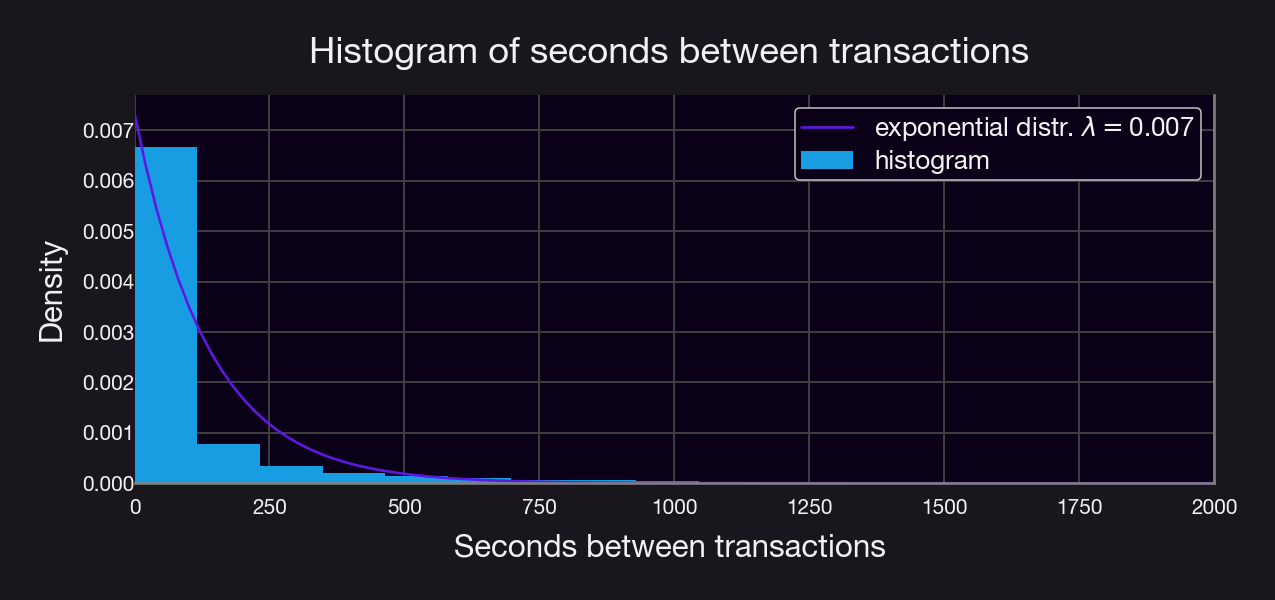

In [163]:
import numpy as np
df=df.sort_values(by='block_timestamp')
df['block_timestamp']=pd.to_datetime(df['block_timestamp'])
aa=df['block_timestamp'].diff().dropna().astype('timedelta64[s]')
lam=1/np.mean(aa)
pdf= lambda x,l:l*np.exp(-l*x)
x=np.linspace(0,2000,100)
plt.plot(x,pdf(x,lam),label=f'exponential distr. $\lambda=$'+str(round(lam,3)))
plt.hist(aa,bins=200, density=True,label='histogram')
plt.title('Histogram of seconds between transactions ')
plt.xlabel('Seconds between transactions ')
plt.ylabel('Density')
plt.legend()
plt.xlim([0,2000])
plt.savefig('secondsBetweenTrx.png')

In [164]:
1/lam

136.2000659389528